In [2]:
from adodbapi.ado_consts import directions
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import multiprocessing
import sys
import cartopy.feature as cfeature
import cmaps
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tq
import xarray as xr
from cartopy import crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.pyplot import quiverkey
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import filters

from toolbar.significance_test import corr_test
from toolbar.TN_WaveActivityFlux import TN_WAF_3D
from toolbar.curved_quivers.modplot import *
from toolbar.data_read import *

def corr(time_series, data):
    # 计算相关系数
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以标准化
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（标准差乘积）
    denominator = np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2))

    # 相关系数
    correlation = numerator / denominator

    # 重塑为 (lat, lon)
    correlation_map = correlation.reshape(data.shape[1:])
    return correlation_map

K_type = xr.open_dataset(r"D:/PyFile/p2/data/Time_type_35_0.1_4.nc")
# z
z_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'z')
z_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'z')
z = xr.concat([z_high, z_low], dim='level')
# u
u_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'u')
u_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'u')
u = xr.concat([u_high, u_low], dim='level')
# v
v_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'v')
v_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'v')
v = xr.concat([v_high, v_low], dim='level')
# t
t_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 't')
t_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 't')
t = xr.concat([t_high, t_low], dim='level')
# pre
pre = prec("E:/data/NOAA/PREC/precip.mon.anom.nc", 1961, 2022)
# sst
sst = ersst("E:/data/NOAA/ERSSTv5/sst.mnmean.nc", 1961, 2022)

In [3]:
Z = z.sel(time=slice('1961-01-01', '2022-12-31'))
Z = Z.sel(time=Z['time.month'].isin([6, 7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
U = u.sel(time=slice('1961-01-01', '2022-12-31'))
U = U.sel(time=U['time.month'].isin([6, 7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
V = v.sel(time=slice('1961-01-01', '2022-12-31'))
V = V.sel(time=V['time.month'].isin([6, 7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
T = t.sel(time=slice('1961-01-01', '2022-12-31'))
T = T.sel(time=T['time.month'].isin([6, 7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
Pre = pre.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=pre['time.month'].isin([6, 7, 8])).groupby('time.year').mean('time').transpose('year', 'lat', 'lon')
Sst = sst.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=sst['time.month'].isin([6, 7, 8])).groupby('time.year').mean('time').transpose('year', 'lat', 'lon')

In [4]:
# 计算相关系数
corr_z = np.zeros((len(K_type['type']), len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z = np.zeros((len(K_type['type']), len(Z['level']), len(Z['lat']), len(Z['lon'])))
corr_u = np.zeros((len(K_type['type']), len(U['level']), len(U['lat']), len(U['lon'])))
corr_v = np.zeros((len(K_type['type']), len(V['level']), len(V['lat']), len(V['lon'])))
corr_t = np.zeros((len(K_type['type']), len(T['level']), len(T['lat']), len(T['lon'])))
corr_pre = np.zeros((len(K_type['type']), len(Pre['lat']), len(Pre['lon'])))
corr_sst = np.zeros((len(K_type['type']), len(Sst['lat']), len(Sst['lon'])))

for i in tq.trange(len(K_type['type'])):
    time_series = K_type.sel(type=i+1)['K'].data
    time_series = time_series - np.polyval(np.polyfit(range(len(time_series)), time_series, 1), range(len(time_series)))
    for j in tq.trange(len(z['level'])):
        lev = z['level'][j].data
        corr_z[i, j] = corr(time_series, Z['z'].sel(level=lev).data)
        corr_u[i, j] = corr(time_series, U['u'].sel(level=lev).data)
        corr_v[i, j] = corr(time_series, V['v'].sel(level=lev).data)
        corr_t[i, j] = corr(time_series, T['t'].sel(level=lev).data)
        reg_z[i, j] = np.array([np.polyfit(time_series, f, 1)[0] for f in Z['z'].sel(level=lev).transpose('lat', 'lon', 'year').data.reshape(-1,len(time_series))]).reshape(Z['z'].sel(level=lev).data.shape[1], Z['z'].sel(level=lev).data.shape[2])
    corr_pre[i] = corr(time_series, Pre['pre'].data)
    corr_sst[i] = corr(time_series, Sst['sst'].data)
    # 将z回归到time_series

100%|██████████| 4/4 [04:01<00:00, 60.39s/it]


In [5]:
def latlon_fmt(ax, xticks1, yticks1, xmajorLocator, xminorLocator, ymajorLocator, yminorLocator):
    ax.set_yticks(yticks1, crs=ccrs.PlateCarree())
    ax.set_xticks(xticks1, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(which='major', length=4, width=.5, color='black')
    ax.tick_params(which='minor', length=2, width=.2, color='black')
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['ytick.direction'] = 'out'
    ax.tick_params(axis='both', labelsize=6, colors='black')

  0%|          | 0/4 [00:00<?, ?it/s]D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 179/179 [00:00<00:00, 262.44条/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 703/703 [00:01<00:00, 390.72条/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 704/704 [00:01<00:00, 405.69条/s]


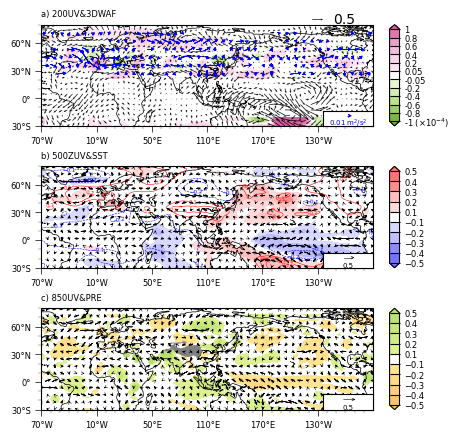

 25%|██▌       | 1/4 [02:05<06:17, 125.83s/it]D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 151/151 [00:00<00:00, 252.43条/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 703/703 [00:01<00:00, 536.30条/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 703/703 [00:01<00:00, 537.66条/s]


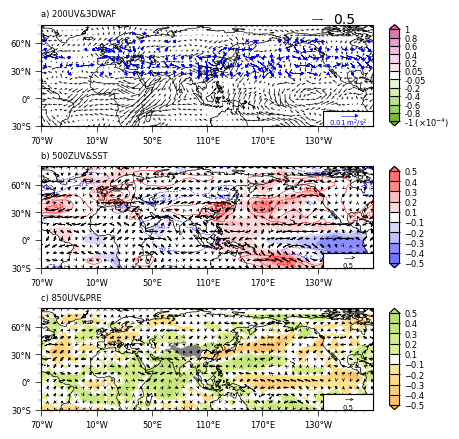

 50%|█████     | 2/4 [04:07<04:06, 123.16s/it]D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 200/200 [00:00<00:00, 305.51条/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 703/703 [00:01<00:00, 473.77条/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 701/701 [00:01<00:00, 611.00条/s]


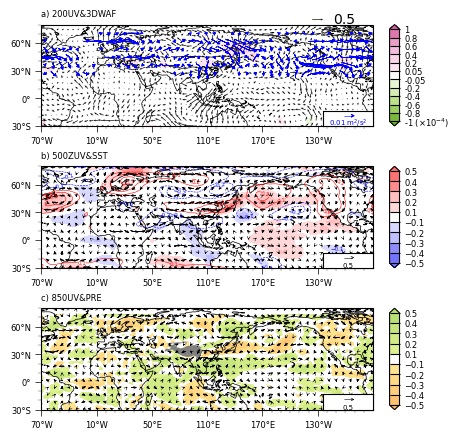

 75%|███████▌  | 3/4 [06:17<02:06, 126.58s/it]D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 186/186 [00:00<00:00, 280.17条/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 703/703 [00:01<00:00, 619.76条/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:212: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)

绘制曲轴矢量: 100%|██████████| 703/703 [00:01<00:00, 567.16条/s]


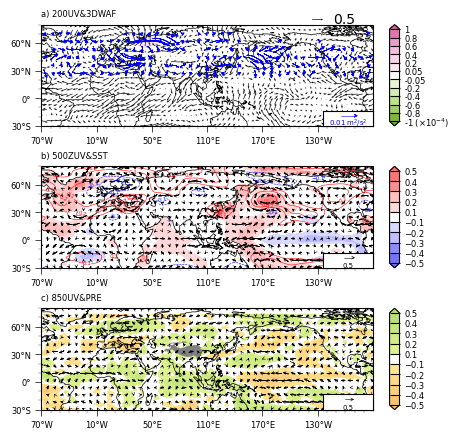

100%|██████████| 4/4 [08:40<00:00, 130.06s/it]


In [20]:
# 绘图
for ipic in tq.trange(len(K_type['type'])):
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    gs = gridspec.GridSpec(3, 1)
    xticks1 = np.arange(-180, 180, 10)
    yticks1 = np.arange(-30, 81, 30)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180-70))
    ax1.set_title(f"a) 200UV&3DWAF", fontsize=6, loc='left')
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    ax1.set_extent([-180, 180, -30, 80], crs=ccrs.PlateCarree(central_longitude=0))
    latlon_fmt(ax1, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z[ipic, 1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    waf_, lon = add_cyclic_point(waf_z[1], coord=waf_z['lon'])
    waf_contf = ax1.contourf(lon, waf_z['lat'], waf_,
                                           levels=np.array([-.5, -.4, -.3, -.2, -.1, -.05, .05, .1, .2, .3, .4, .5])*1e-4,
                                           cmap=cmaps.MPL_PiYG_r[11+10:55]+ cmaps.CBR_wet[0] + cmaps.CBR_wet[0] + cmaps.CBR_wet[0] + cmaps.CBR_wet[0] + cmaps.CBR_wet[0] + cmaps.CBR_wet[0] + cmaps.MPL_PiYG_r[72:116-10],
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_speed = np.sqrt(waf_x[1] ** 2 + waf_y[1] ** 2)
    waf_speed_50 = np.nanpercentile(waf_speed, 50)
    waf_speed_mask = np.where(waf_speed > waf_speed_50, 1, 0)
    waf_x_mask = waf_speed_mask * waf_x[1]
    waf_y_mask = waf_speed_mask * waf_y[1]
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x_mask[:180, :], waf_y_mask[:180, :],
                                  regrid=10, lon_trunc=-70, arrowsize=.5, scale=8, linewidth=0.4,
                                  color='blue', transform=ccrs.PlateCarree(central_longitude=0), arrowstyle='fancy')
    WAF_cq.key(fig, U=.001, label='0.01 m$^2$/s$^2$')
    # wind
    wind = ax1.quiver(U['lon'], U['lat'], corr_u[ipic, 2, :, :], corr_v[ipic, 2, :, :], transform=ccrs.PlateCarree(central_longitude=0), scale=15, width=0.002, headwidth=3, headlength=4, headaxislength=3, regrid_shape=20)
    ax1.quiverkey(wind, 0.85, 1.05, .5, r'0.5', labelpos='E')
    # 色标
    ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb1 = plt.colorbar(waf_contf, cax=ax1_colorbar, orientation='vertical')
    cb1.locator = ticker.FixedLocator(np.array([-.5, -.4, -.3, -.2, -.1, -.05, .05, .1, .2, .3, .4, .5])*1e-4)
    cb1.set_ticklabels(['-1 ($×10^{-4}$)', '-0.8', '-0.6', '-0.4', '-0.2', '-0.05','0.05','0.2','0.4','0.6','0.8','1'])
    cb1.ax.tick_params(length=7, labelsize=6, direction='in')  # length为刻度线的长度

    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180-70))
    ax2.set_title(f"b) 500ZUV&SST", fontsize=6, loc='left')
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    ax2.set_extent([-180, 180, -30, 80], crs=ccrs.PlateCarree(central_longitude=0))
    latlon_fmt(ax2, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    z_high = ax2.contour(Z['lon'], Z['lat'], corr_z[ipic, 3, :, :], colors='red', levels=[.1, .2, .3, .4, .5], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], corr_z[ipic, 3, :, :], colors='blue', levels=[-.5,-.4,-.3,-.2,-.1], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    # sst
    sst = ax2.contourf(Sst['lon'], Sst['lat'], corr_sst[ipic, :, :], cmap=cmaps.GMT_polar[4:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-4], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], corr_u[ipic, 3, :, :], corr_v[ipic, 3, :, :],
                                  lon_trunc=-70, arrowsize=.5, scale=40, linewidth=0.4, regrid=15,
                                  transform=ccrs.PlateCarree(central_longitude=0))
    wind.key(fig, U=0.5, label='0.5')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical')
    cb2.ax.tick_params(length=7, labelsize=6, direction='in')  # length为刻度线的长度

    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180-70))
    ax3.set_title(f"c) 850UV&PRE", fontsize=6, loc='left')
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=2)
    ax3.set_extent([-180, 180, -30, 80], crs=ccrs.PlateCarree(central_longitude=0))
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(60), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # pre
    pre = ax3.contourf(Pre['lon'], Pre['lat'], corr_pre[ipic, :, :], cmap=cmaps.MPL_RdYlGn[32+10:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:96-10], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], corr_u[ipic, 4, :, :], corr_v[ipic, 4, :, :],
                                  lon_trunc=-70, arrowsize=.5, scale=40, linewidth=0.4, regrid=15,
                                  transform=ccrs.PlateCarree(central_longitude=0))
    wind.key(fig, U=0.5, label='0.5')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax3.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical')
    cb3.ax.tick_params(length=7, labelsize=6, direction='in')  # length为刻度线的长度
    plt.savefig(f'D:/PyFile/p2/pic/各空间型异常环流场{ipic}.png', dpi=600, bbox_inches='tight')
    plt.show()
